Features that most likely decide the price of the mobile (sorted by correlation):
Spec_score: 0.63
Display: 0.47
Inbuilt_memory_ 512 GB inbuilt: 0.44
Inbuilt_memory_ 256 GB inbuilt: 0.36
No_of_sim_Dual Sim, 3G, 4G, 5G, VoLTE, Vo5G, : 0.35
Ram_16 GB RAM: 0.28
fast_charging_ 66W Fast Charging: 0.27
Processor_name: 0.21


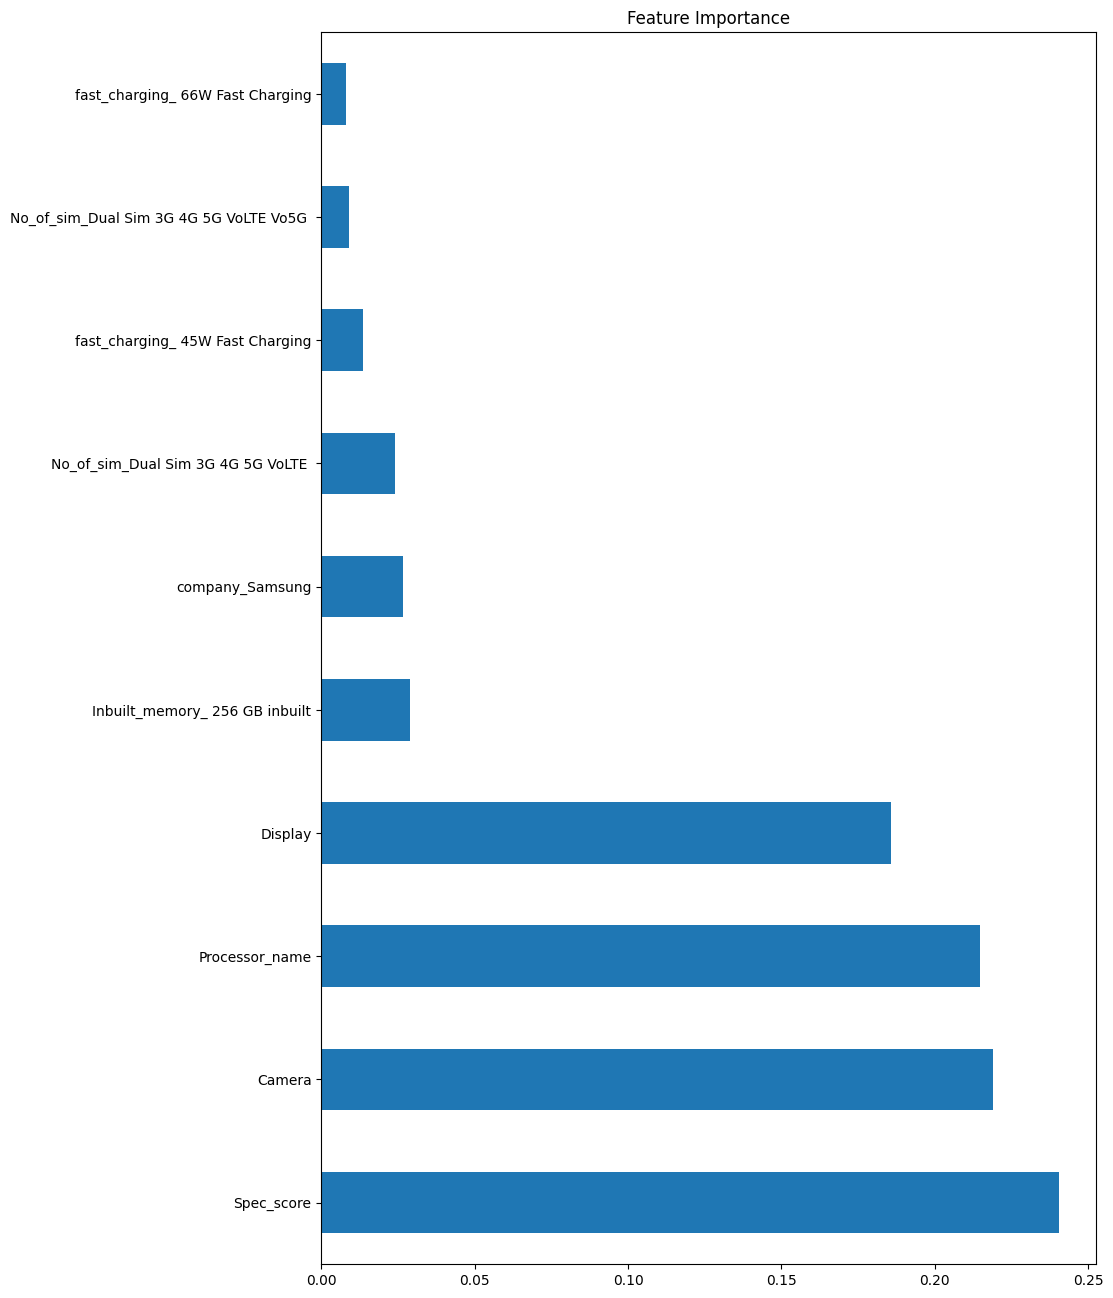

 55%|█████▍    | 23/42 [00:04<00:02,  9.18it/s]C:\Users\MSUSERSL123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\MSUSERSL123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 74%|███████▍  | 31/42 [00:05<00:01,  7.79it/s]C:\Users\MSUSERSL123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_quantile.py:186: FutureWarning: The default solver will change from 

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:08<00:00,  5.10it/s]


Best parameters found: ExtraTreesRegressor()
RMSE : 11960.953938960192
R2L 0.8421060097458475


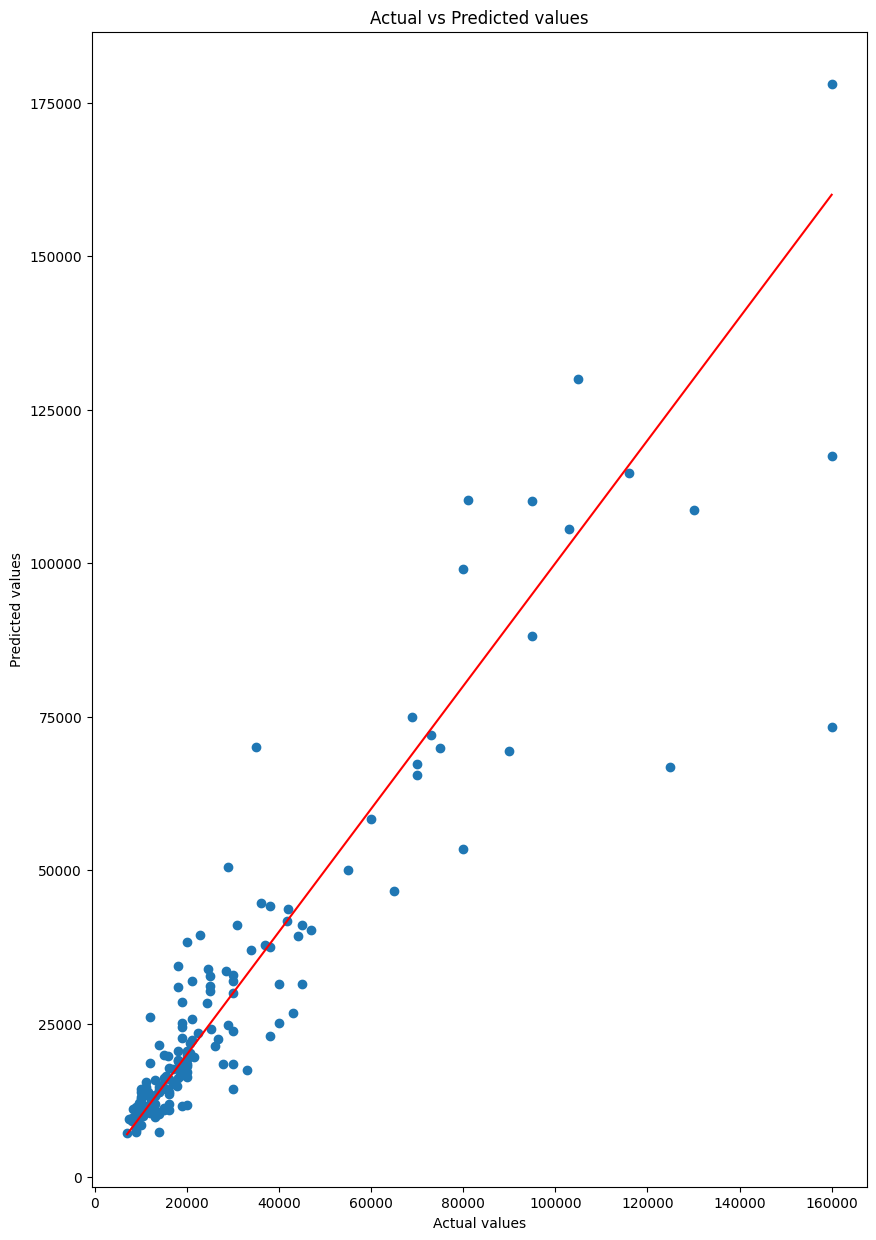

In [4]:
!pip install lazypredict

from re import VERBOSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error,r2_score
from lazypredict.Supervised import LazyRegressor


def dataCheck(df):
  print('Data Info','\n')
  print(df.info(),'\n')
  print('Data Shape','\n')
  print(df.shape,'\n')
  print('Describe','\n')
  print(df.describe,'\n')
  print('describe with object','\n')
  print(df.describe(include='object'),'\n')
  print('NULL info')
  print(df.isnull().sum(),'\n')
  print('Duplicated data','\n')
  print(df.duplicated().sum(),'\n')
  print('Unique','\n')
  print(df.nunique())

df = pd.read_csv("mobile phone price prediction.csv")
#dataCheck(df)
df = df.dropna()
df = df.drop_duplicates()
#print(df)
df.drop(columns=['Unnamed: 0','Name'],inplace=True)
df['Price']=df['Price'].str.replace(',', '').astype(float) # Convert the 'Price' column to a numerical type

categorical_columns = df.select_dtypes(include=['object','category']).columns.to_list()
#print(categorical_columns)
# Fill missing values with the mode of each column
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

le = LabelEncoder()
categorical_columns = ['Camera', 'Processor_name', 'Screen_resolution', 'Display', 'Battery', 'External_Memory']
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])
#print(df)
df.drop_duplicates(inplace=True) # Remove duplicate rows if any

#get the onehot encoding.
dummie_df = pd.get_dummies(df, drop_first=True) # Create dummy variables for categorical features
dummie_df.shape

price_corr = dummie_df.corr()['Price'].drop('Price')

# Identify features with a correlation greater than 0.15 with the target variable
corr_u =dummie_df.corr()['Price'].sort_values(ascending=False, key=abs)>0.15
corr_u.index = corr_u.index.str.replace(',','')
dummie_df.columns=dummie_df.columns.str.replace(',','')



# Drop features with low correlation
for i in range(len(corr_u)):
    if corr_u[i] == False:
        dummie_df.drop(columns=corr_u.index[i], inplace=True)
#print('dummie_df',dummie_df)

# Extract correlations with respect to 'Price'

# Sort correlations in descending order
sorted_price_corr = price_corr.sort_values(ascending=False)

# Print the features that are most likely to decide the price of the mobile
print("Features that most likely decide the price of the mobile (sorted by correlation):")
for feature, corr_value in sorted_price_corr.items():
    if corr_value >0.20:
      print(f"{feature}: {corr_value:.2f}")

# plt.figure(figsize=(12,15))
# sns.heatmap(dummie_df.corr())
# plt.show()
#print(price_corr)

#Model Evaluation and training

X= dummie_df.drop(columns='Price')
y= dummie_df["Price"]

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

#Model
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

plt.figure(figsize =(10,16))
predicted_features = pd.Series(rf.feature_importances_,index=X.columns)
predicted_features.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.show()

lr = LazyRegressor(verbose=0,ignore_warnings=False,custom_metric=None)

models,predictions = lr.fit(X_train,X_test, y_train,y_test)

models

#Model Tuning
# Replace whitespace in feature names
X_train.columns = [col.replace(" ", "_") for col in X_train.columns]
X_test.columns = [col.replace(" ", "_") for col in X_test.columns]

param_grid = {

}

trees = ExtraTreesRegressor()
grid_search = GridSearchCV(estimator=trees,param_grid=param_grid,cv=3,scoring='neg_mean_squared_error',n_jobs=-1)
grid_search.fit(X_train,y_train)
print('Best parameters found:',grid_search.best_estimator_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test,y_pred,squared=False)
r2 = r2_score(y_test,y_pred)

print('RMSE :',rmse)
print('R2L',r2)


plt.figure(figsize=(10,15))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title("Actual vs Predicted values")
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],color='red')
plt.show()

